# 预训练数据
- 高质量的预训练数据是训练高质量模型的基础
- 预训练数据来源于大量无标注文本
- 训练所需的数据
    - 其实对于预训练的大模型而言，一般使用的就是像是书本、代码、文章、维基百科、网络页面等等这部分内容来训练。而对于模型微调而言，则是通过人类或机器生成的对话对（一问一答）来进行训练的。
- 数据的质量
    - 对于预训练模型还是说微调模型而言，数据的质量都是至关重要的。不好的数据总是重复的、有误的、不连贯的、有不安全信息的。
    
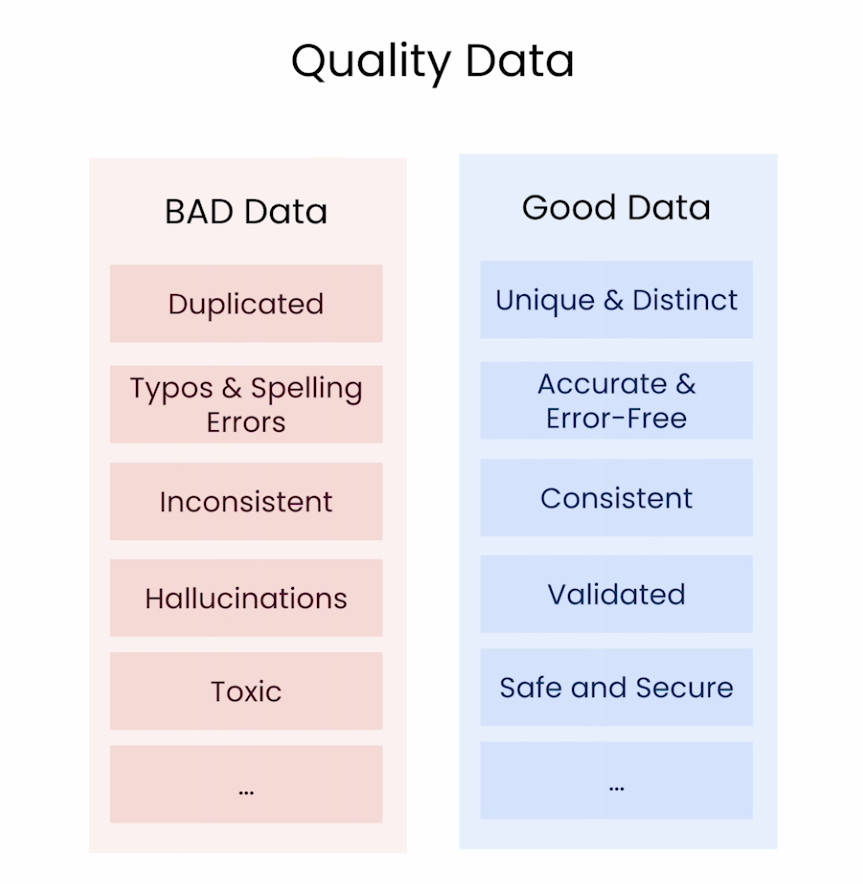

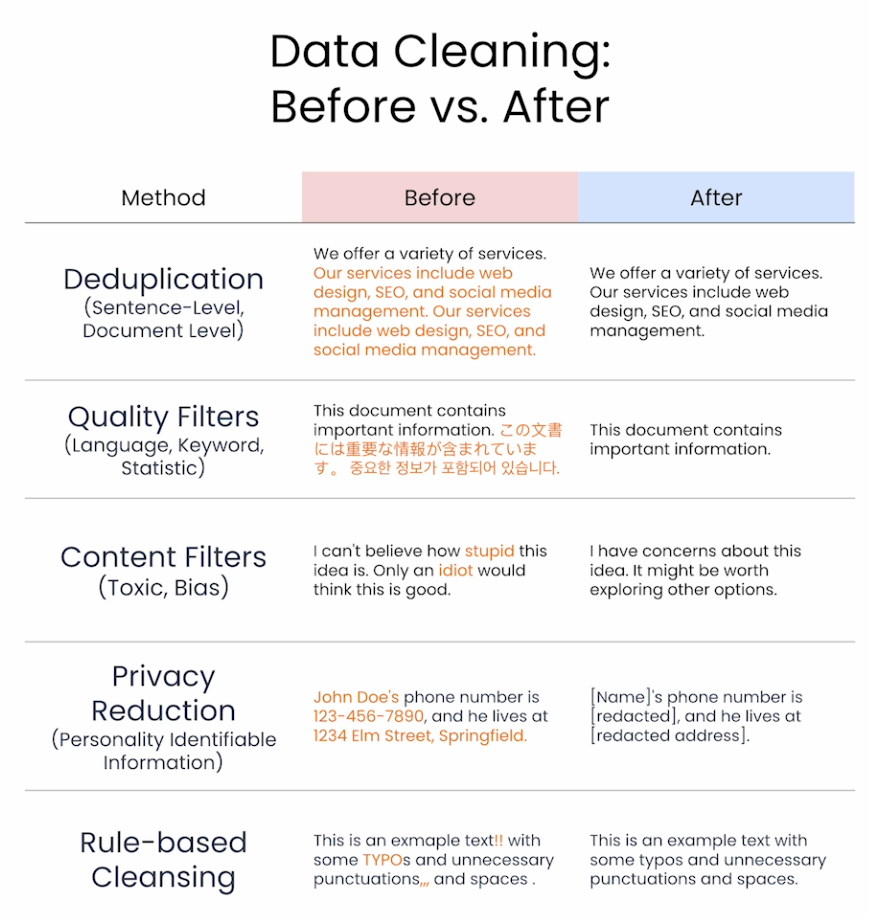

清洗数据方式：
- 语句重复
- 清楚不相关文本（比如非目标种类语言）
- 脏话
- 隐私
- 基于规则清洗数据

实际使用
那在具体的实操过程中，课程展示了四步的数据清理：

1.筛选出过短的内容并删掉

由于过短的内容并不会有很丰富的语义信息，所以我们会筛选掉那些少于3行的文字，从而保证整体的数据质量。

2.删除重复的内容和信息

我们需要找到前一句和后一句内文字重复大于20%的内容，然后将其中一句删掉，从而保证前后的内容不要过分的重复。

3.删除重复的文档

除了内部的一些语句的重复以外，假如有相同的文档进行训练的话也会影响整体模型的效果。比如在书生浦语实战训练营中，我们就曾试过用一句话重复2w遍然后给大模型微调，然后发现得到的模型就只会说这一句话了。因此也可以看出太多重复的内容会真的影响模型的输出。

4.删除无关的语言

假如我们训练的模型是特定的语言，我们就需要删掉除该语言以外的内容从而保证其纯粹性。当然就像人类一样，多语其实会让孩子脑子开发更多，但是假如其均衡性不能得到很好的保证的话，对于大语言模型而言还不如只保留其中一种从而避免出错。

## 数据预处理开源工具
- Dataverse
- Label LLM

## 1、数据预处理

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import datasets
pretraining_dataset = datasets.load_dataset(
    "upstage/Pretraining_Dataset",  # Red Pajama数据集的子集
    split="train"
)

In [ ]:
print(pretraining_dataset)

In [ ]:
pretraining_dataset = pretraining_dataset.select_columns(["text"])

In [ ]:
print(pretraining_dataset[0]["text"][:500])

## 对比预训练和微调数据集

In [ ]:
instruction_dataset = datasets.load_dataset(
    "c-s-ale/alpaca-gpt4-data",
    split='train'
)
print(instruction_dataset)

In [ ]:
i = 0
print("Instruction: " + instruction_dataset[i]["instruction"]
      + "\nInput: " + instruction_dataset[i]["input"]
      + "\nOutput: " + instruction_dataset[i]["output"])

## 通过URL获取数据

In [ ]:
# Import some required packages
import os
import requests

# Path to directory to store python scripts
code_dir = "./code"

In [ ]:
urls = [
    "https://raw.githubusercontent.com/TheAlgorithms/Python/master/searches/double_linear_search_recursion.py",
    "https://raw.githubusercontent.com/KosingZhu/tensorflow/master/tensorflow/python/tools/module_util.py",
    "https://raw.githubusercontent.com/EricRemmerswaal/tensorflow/master/tensorflow/python/distribute/distribute_coordinator_context.py",
    "https://raw.githubusercontent.com/computationalartist/tensorflow/master/tensorflow/python/ops/numpy_ops/integration_test/benchmarks/numpy_mlp.py",
    "https://raw.githubusercontent.com/Van-an/tensorflow/master/tensorflow/python/distribute/coordinator/values.py",
    "https://raw.githubusercontent.com/nkgwer/tensorflow/master/tensorflow/lite/tools/visualize.py",
    "https://raw.githubusercontent.com/gitblazer/youtube-dl/master/youtube_dl/version.py",
    "https://raw.githubusercontent.com/Joshua-Barawa/My-Photos/master/venv/lib/python3.8/site-packages/django/contrib/messages/__init__.py",
    "https://raw.githubusercontent.com/PaliC/pytorch/master/test/fx/test_subgraph_rewriter.py"
]

In [ ]:
# 通过URL下载文件并保存到本地
for url in urls:
    print(f"Working on url: {url}")
    response = requests.get(url)
    file_name = os.path.basename(url)
    file_path = os.path.join(code_dir, file_name)

    with open(file_path, "wb") as file:
        file.write(response.content)

In [ ]:
files = os.listdir(code_dir)
for file in files:
    print(file)

In [ ]:
code_dataset = []
for file in os.listdir(code_dir):
    code_dataset.append(
        {'text': open(os.path.join(code_dir, file), 'r').read()}
    )

In [ ]:
# 将列表转换为huggingface datasets格式
code_dataset = datasets.Dataset.from_list(code_dataset)
print(code_dataset)

In [ ]:
# 将两个数据集合并
dataset = datasets.concatenate_datasets(
    [pretraining_dataset, code_dataset]
)
print(dataset)

## 2、数据清洗

- 过滤掉太短的样本
- 删除单个文本示例中的重复部分
- 删除重复的文档
- 质量过滤器，以删除非英语文本

In [ ]:
dataset.num_rows

过滤掉太短的样本

In [ ]:
import heapq


def paragraph_length_filter(x):
    """Returns False iff a page has too few lines or lines are too short."""
    lines = x['text'].split('\n')
    if (
        len(lines) < 3
        or min(heapq.nlargest(3, [len(line) for line in lines])) < 3
    ):  # 检查行数小于3或者lines列表中最长的三行的最小长度是否小于3个字符
        return False
    return True

In [ ]:
dataset = dataset.filter(
    paragraph_length_filter,
    load_from_cache_file=False  # 由于数据集很大，我们不希望将其缓存到磁盘
)

In [ ]:
dataset.num_rows

删除单个文本示例中的重复部分

In [ ]:
def find_duplicates(paragraphs):
    """
    Use this function to find the number of repetitions 
    in the paragraphs.
    """
    unique_x = set()
    duplicate_chars = 0
    duplicate_elements = 0
    for element in paragraphs:
        if element in unique_x:
            duplicate_chars += len(element)
            duplicate_elements += 1
        else:
            unique_x.add(element)
    return duplicate_elements, duplicate_chars

In [ ]:
import re


def paragraph_repetition_filter(x):
    """
    Returns False iff a page has too many repetitions.
    """
    text = x['text']
    # Split by paragraphs (2 or more newlines)
    paragraphs = re.compile(r"\n{2,}").split(text.strip())
    paragraphs_duplicates, char_duplicates = find_duplicates(paragraphs)  # Find number of duplicates in paragraphs
    if paragraphs_duplicates / len(paragraphs) > 0.3:
        return False
    if char_duplicates / len(text) > 0.2:
        return False
    return True

In [ ]:
dataset = dataset.filter(
    paragraph_repetition_filter,
    load_from_cache_file=False
)

In [ ]:
dataset.num_rows

删除重复的文档

In [ ]:
def deduplication(ds):
    def dedup_func(x):
        """Use this function to remove duplicate entries"""
        if x['text'] in unique_text:
            return False
        else:
            unique_text.add(x['text'])
            return True

    unique_text = set()

    ds = ds.filter(dedup_func, load_from_cache_file=False, num_proc=1)
    return ds


dataset = deduplication(dataset)

In [ ]:
dataset.num_rows

质量过滤器，以删除非英语文本

In [ ]:
!pip install fasttext

In [ ]:
import urllib
from fasttext.FastText import _FastText


def english_language_filter(ds):
    # load language detection model
    model = _FastText('./models/L2_language_model.bin')

    def is_english(x):
        # Predict language of the text and probability
        language, score = model.predict(x['text'].replace("\n", ""))

        language = language[0].split("__")[2]
        # change code here if building a model in another language
        return score > 0.4 and language == "en"

    ds = ds.filter(is_english, load_from_cache_file=False, num_proc=1)
    return ds


dataset = english_language_filter(dataset)

In [ ]:
dataset.num_rows

保存数据

In [ ]:
file_path = "./data/preprocessed_dataset.parquet"
dataset.to_parquet(file_path)  # 保存数据集到本地